- Developed a machine learning model to predict the hourly taxi passenger count.
- The model does not take into account the taxi zone, so the only input is time.
- xgboost algorithm was used, optimal parameters were determind using Hyperparameter Optimization study with Optuna.
- next step is to include the taxi zone data and the subway ridership!

Results:
- Root Mean Squared Error (RMSE): 606.45
- R-squared (R2): 0.99
- Relative RMSE (as a percentage of mean): 6.47%
- Relative RMSE (as a percentage of median): 5.84%


In [130]:
import json
!pip install optuna
import optuna
from shapely.geometry import shape, Point
import os
!pip install python-dotenv
from dotenv import load_dotenv
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import xgboost as xgb
load_dotenv('/content/.env')


True

In [102]:
# Download the file from Google Drive using the file ID

!gdown {os.getenv('cleaned-taxi-data')}

Downloading...
From: https://drive.google.com/uc?id=14frcdxZ8bvsq1yed8sB9kk0_XbIImXnr
To: /content/combined_taxi_df.csv
100% 84.3M/84.3M [00:00<00:00, 172MB/s]


In [103]:
#load the taxi dataset into a df
taxi_df = pd.read_csv('/content/combined_taxi_df.csv')

taxi_df.head()

,datetime_formatted,hour,day_of_week,week,month,day_of_month,year_month,zone,passenger_count
0,2021-01-01 00:00:00,0,4,53,0,1,2021-01,4,4
1,2021-01-01 00:00:00,0,4,53,0,1,2021-01,13,3
2,2021-01-01 00:00:00,0,4,53,0,1,2021-01,24,3
3,2021-01-01 00:00:00,0,4,53,0,1,2021-01,41,12
4,2021-01-01 00:00:00,0,4,53,0,1,2021-01,42,2


In [104]:
#drop all columns except of datetime_formated and passenger_count
taxi_df = taxi_df[["datetime_formatted", "passenger_count"]].reset_index(drop=True)

In [105]:
#rename datetime_formatted to transit_timestamp
taxi_df.rename(columns={'datetime_formatted': 'transit_timestamp'}, inplace=True)

In [106]:
#group df by datetime_formatted
taxi_df = taxi_df.groupby('transit_timestamp').sum().reset_index()

In [107]:
taxi_df.head()

,transit_timestamp,passenger_count
0,2021-01-01 00:00:00,981
1,2021-01-01 01:00:00,2994
2,2021-01-01 02:00:00,2623
3,2021-01-01 03:00:00,1435
4,2021-01-01 04:00:00,723


In [108]:
#get the number of rows after grouping
taxi_df.shape

(28465, 2)

In [109]:
taxi_df.dtypes

transit_timestamp    object
passenger_count       int64
dtype: object

In [110]:
#what is the max and min dates in the df
print(taxi_df['transit_timestamp'].min())
print(taxi_df['transit_timestamp'].max())

2021-01-01 00:00:00
2024-04-01 00:00:00


In [111]:
vdf = taxi_df.copy()

In [112]:
# Convert 'datetime_formatted' column to datetime
vdf['transit_timestamp'] = pd.to_datetime(vdf['transit_timestamp'])

# Extract date and assign to 'date' column
vdf["date"] = vdf["transit_timestamp"].dt.date

# Group by 'date', sum values, and reset index
vdf = vdf.groupby('date', as_index=False)['passenger_count'].sum()



In [113]:
vdf.dtypes

date               object
passenger_count     int64
dtype: object

In [114]:
vdf.head()

,date,passenger_count
0,2021-01-01,54475
1,2021-01-02,79518
2,2021-01-03,55446
3,2021-01-04,94444
4,2021-01-05,100924


In [115]:
#return rows for which passenger count is very small!!
low_days = vdf[vdf['passenger_count'] <= 50000]

low_days.head()

,date,passenger_count
31,2021-02-01,12633
625,2022-09-18,2199
994,2023-09-22,2821
995,2023-09-23,1855
996,2023-09-24,1974


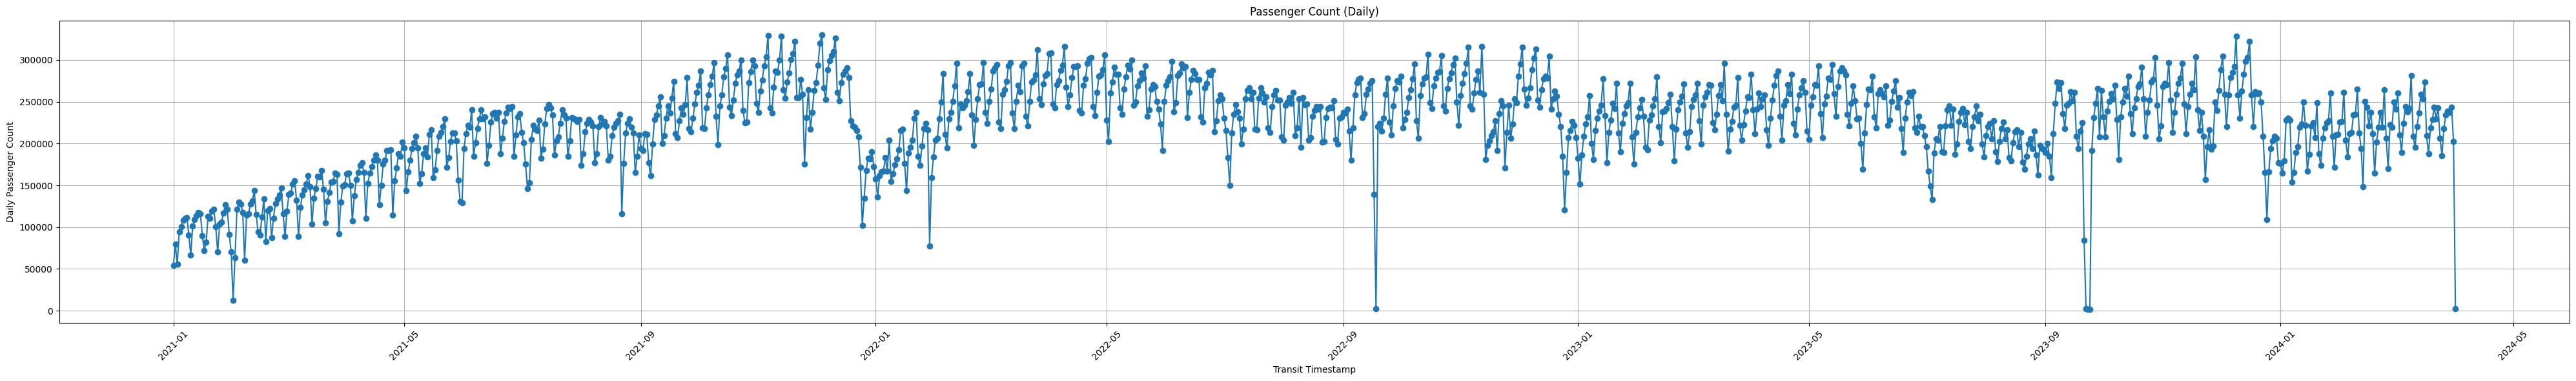

In [116]:
#plot the daily passenger counts
plt.figure(figsize=(40, 6))
plt.plot(vdf['date'], vdf['passenger_count'], marker='o')
plt.xlabel('Transit Timestamp')
plt.ylabel('Daily Passenger Count')
plt.title('Passenger Count (Daily)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [117]:
df = taxi_df.copy()

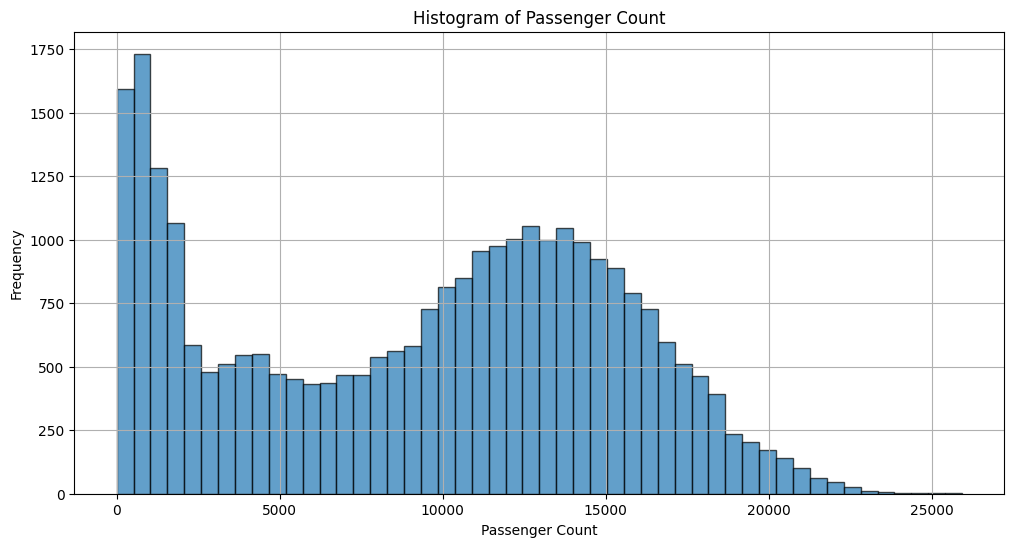

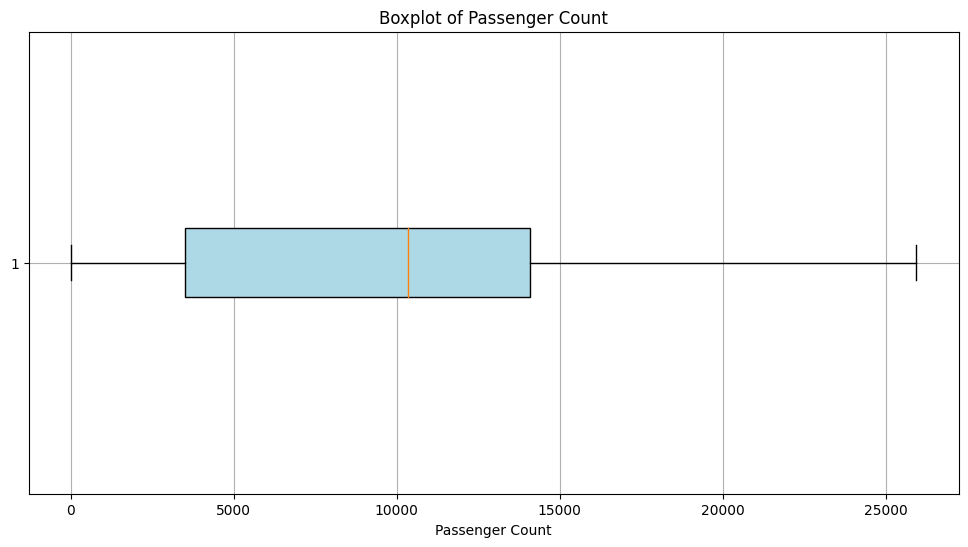

In [119]:
# Plot the histogram of the passenger count
plt.figure(figsize=(12, 6))
plt.hist(df['passenger_count'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot the boxplot of the passenger count
plt.figure(figsize=(12, 6))
plt.boxplot(df['passenger_count'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot of Passenger Count')
plt.xlabel('Passenger Count')
plt.grid(True)
plt.show()


In [121]:
# change the transit_timestamp into a datetime object
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])


In [122]:
#chack new types now
df.dtypes

transit_timestamp    datetime64[ns]
passenger_count               int64
dtype: object

In [123]:
df.head()

,transit_timestamp,passenger_count
0,2021-01-01 00:00:00,981
1,2021-01-01 01:00:00,2994
2,2021-01-01 02:00:00,2623
3,2021-01-01 03:00:00,1435
4,2021-01-01 04:00:00,723


In [124]:
# Create time-based features

df['hour'] = df['transit_timestamp'].dt.hour
df['day'] = df['transit_timestamp'].dt.day
df['weekday'] = df['transit_timestamp'].dt.weekday
df['week'] = df['transit_timestamp'].dt.isocalendar().week
df['month'] = df['transit_timestamp'].dt.month
df['year'] = df['transit_timestamp'].dt.year

df['weekend'] = df['weekday'] >= 5
df['rush_hour'] = df['hour'].isin([7, 8, 9, 16, 17, 18, 19]) & ~df['weekend']


df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)


df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)


df['year_sin'] = np.sin(2 * np.pi * (df['year'] - df["year"].min()) / (df["year"].max() - df["year"].min() + 1))
df['year_cos'] = np.cos(2 * np.pi * (df['year'] - df["year"].min()) / (df["year"].max() - df["year"].min() + 1))

# Additional features (rolling mean, lag features)
df['rolling_mean_24h'] = df['passenger_count'].rolling(window=24).mean()
df['rolling_std_24h'] = df['passenger_count'].rolling(window=24).std()
df['rolling_mean_7d'] = df['passenger_count'].rolling(window=24*7).mean()
df['rolling_std_7d'] = df['passenger_count'].rolling(window=24*7).std()

# Create lag features
df['lag_1h'] = df['passenger_count'].shift(1)
df['lag_24h'] = df['passenger_count'].shift(24)
df['lag_7d'] = df['passenger_count'].shift(24*7)

# Ensure no NaN values due to new rolling features
df.dropna(inplace=True)

df.reset_index(drop=True, inplace=True)

In [131]:
# Define features and target
X = df[['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'weekday', 'weekend',
        'rolling_mean_24h', 'rolling_std_24h', 'rolling_mean_7d', 'rolling_std_7d',
        'lag_1h', 'lag_24h', 'lag_7d']]
y = df['passenger_count']

# Initialize KFold cross-validation
kf = KFold(n_splits=10, shuffle=False)

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42
    }

    mse_list = []

    # Loop through each fold
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets for this fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Initialize the scaler and scale the data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Initialize the XGBoost regressor
        xgb_regressor = xgb.XGBRegressor(**params)

        # Fit the model
        xgb_regressor.fit(X_train_scaled, y_train)

        # Predictions
        y_pred = xgb_regressor.predict(X_test_scaled)

        # Calculate performance metrics
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse)

    # Return the average MSE over all folds
    return np.mean(mse_list)

# Set up the Optuna study
study = optuna.create_study(direction='minimize')

# Run the optimization
study.optimize(objective, n_trials=50)

# Print the best parameters
print('Best hyperparameters:', study.best_params)

# Best parameters found by Optuna
best_params = study.best_params

[I 2024-06-29 18:08:52,096] A new study created in memory with name: no-name-f9244559-23e6-4631-9d62-b5faba2d1292
[I 2024-06-29 18:09:01,805] Trial 0 finished with value: 441987.7958670291 and parameters: {'n_estimators': 101, 'learning_rate': 0.16227749851297452, 'max_depth': 5, 'subsample': 0.9933991258377886, 'colsample_bytree': 0.7269624396878271, 'min_child_weight': 2, 'reg_alpha': 0.30593609512306197, 'reg_lambda': 0.3676623666375969}. Best is trial 0 with value: 441987.7958670291.
[I 2024-06-29 18:09:23,422] Trial 1 finished with value: 455683.32156724326 and parameters: {'n_estimators': 480, 'learning_rate': 0.08421091817132285, 'max_depth': 10, 'subsample': 0.5897322241778475, 'colsample_bytree': 0.5750785248420189, 'min_child_weight': 5, 'reg_alpha': 0.2348033349876204, 'reg_lambda': 0.16074613746571553}. Best is trial 0 with value: 441987.7958670291.
[I 2024-06-29 18:09:26,063] Trial 2 finished with value: 494870.1920795397 and parameters: {'n_estimators': 236, 'learning_rat

Best hyperparameters: {'n_estimators': 302, 'learning_rate': 0.029828923580071227, 'max_depth': 9, 'subsample': 0.925575886131455, 'colsample_bytree': 0.9341292958759022, 'min_child_weight': 7, 'reg_alpha': 0.4409416173139554, 'reg_lambda': 0.770310242129707}


In [132]:
# Define features and target
X = df[['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'weekday', 'weekend',
        'rolling_mean_24h', 'rolling_std_24h', 'rolling_mean_7d', 'rolling_std_7d',
        'lag_1h', 'lag_24h', 'lag_7d']]
y = df['passenger_count']

# Initialize KFold cross-validation
kf = KFold(n_splits=10, shuffle=False)

# Arrays to store performance metrics for each fold
mse_list = []
rmse_list = []
r2_list = []

# Loop through each fold
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize the scaler and scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize the XGBoost regressor
    xgb_regressor = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=302,
        learning_rate=0.029828923580071227,
        max_depth=9,
        subsample=0.925575886131455,
        colsample_bytree=0.9341292958759022,
        min_child_weight=7,
        reg_alpha=0.4409416173139554,
        reg_lambda=0.770310242129707,
        random_state=42
    )

    # Fit the model
    xgb_regressor.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = xgb_regressor.predict(X_test_scaled)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)



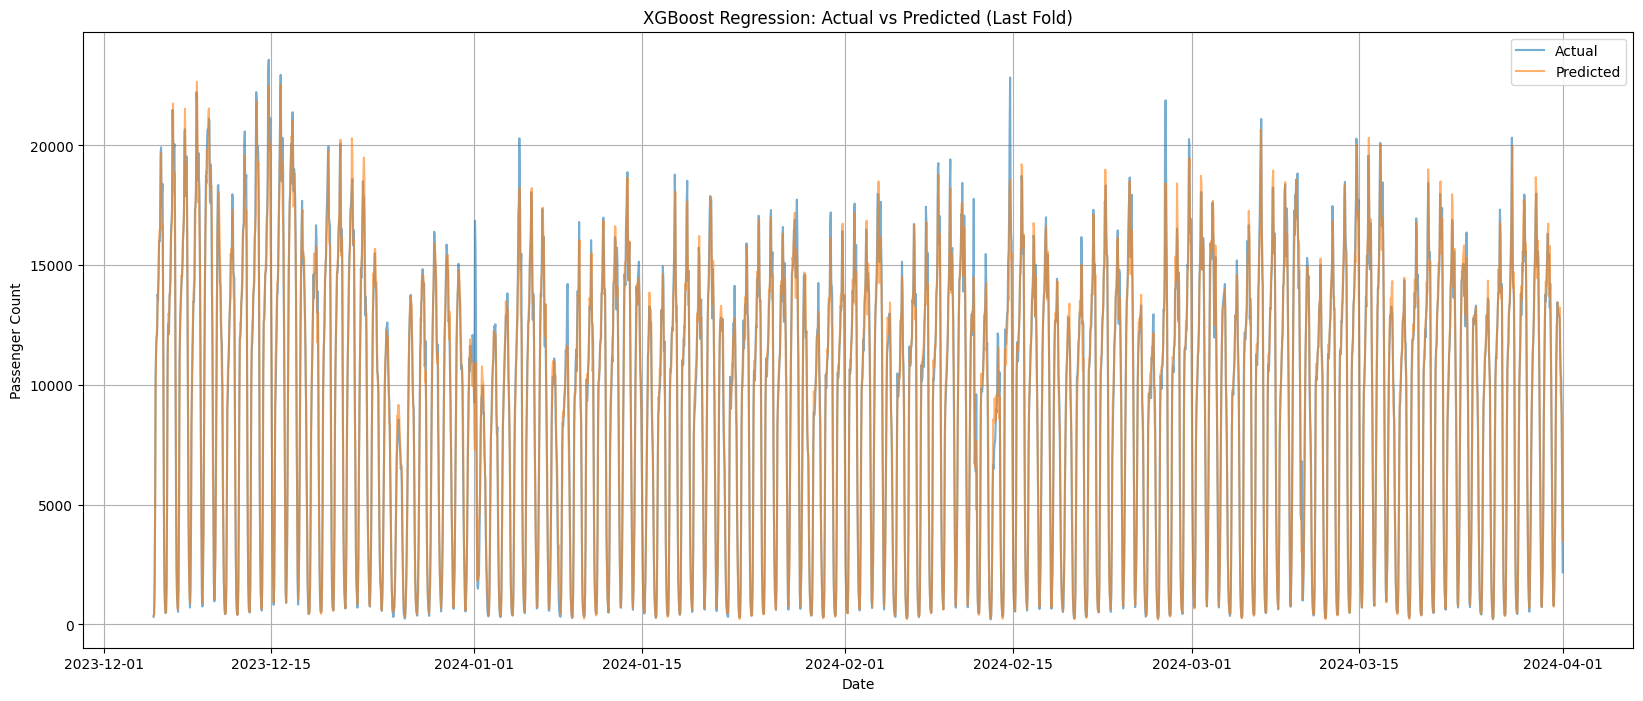

Average Mean Squared Error (MSE): 370680.15
Average Root Mean Squared Error (RMSE): 606.45
Average R-squared (R2): 0.99


In [133]:
    # Plotting predictions vs actual for the last fold
    if len(mse_list) == kf.get_n_splits():
        plt.figure(figsize=(20, 8))
        plt.plot(df['transit_timestamp'].iloc[test_index], y_test, label='Actual', alpha=0.6)
        plt.plot(df['transit_timestamp'].iloc[test_index], y_pred, label='Predicted', alpha=0.6)
        plt.xlabel('Date')
        plt.ylabel('Passenger Count')
        plt.title('XGBoost Regression: Actual vs Predicted (Last Fold)')
        plt.legend()
        plt.grid(True)
        plt.show()

# Print average metrics across all folds
print(f'Average Mean Squared Error (MSE): {np.mean(mse_list):.2f}')
print(f'Average Root Mean Squared Error (RMSE): {np.mean(rmse_list):.2f}')
print(f'Average R-squared (R2): {np.mean(r2_list):.2f}')

In [136]:
mean_passenger_count = df['passenger_count'].mean()
std_passenger_count = df['passenger_count'].std()
median_passenger_count = df['passenger_count'].median()

print(f"Mean Passenger Count: {mean_passenger_count:.2f}")
print(f"Standard Deviation of Passenger Count: {std_passenger_count:.2f}")
print(f"Median Passenger Count: {median_passenger_count:.2f}")

# RMSE value
rmse = np.mean(rmse_list)

# Relative RMSE
relative_rmse_mean = (rmse / mean_passenger_count) * 100
relative_rmse_median = (rmse / median_passenger_count) * 100



print(f"Relative RMSE (as a percentage of mean): {relative_rmse_mean:.2f}%")
print(f"Relative RMSE (as a percentage of median): {relative_rmse_median:.2f}%")

Mean Passenger Count: 9372.77
Standard Deviation of Passenger Count: 5915.31
Median Passenger Count: 10390.00
Relative RMSE (as a percentage of mean): 6.47%
Relative RMSE (as a percentage of median): 5.84%


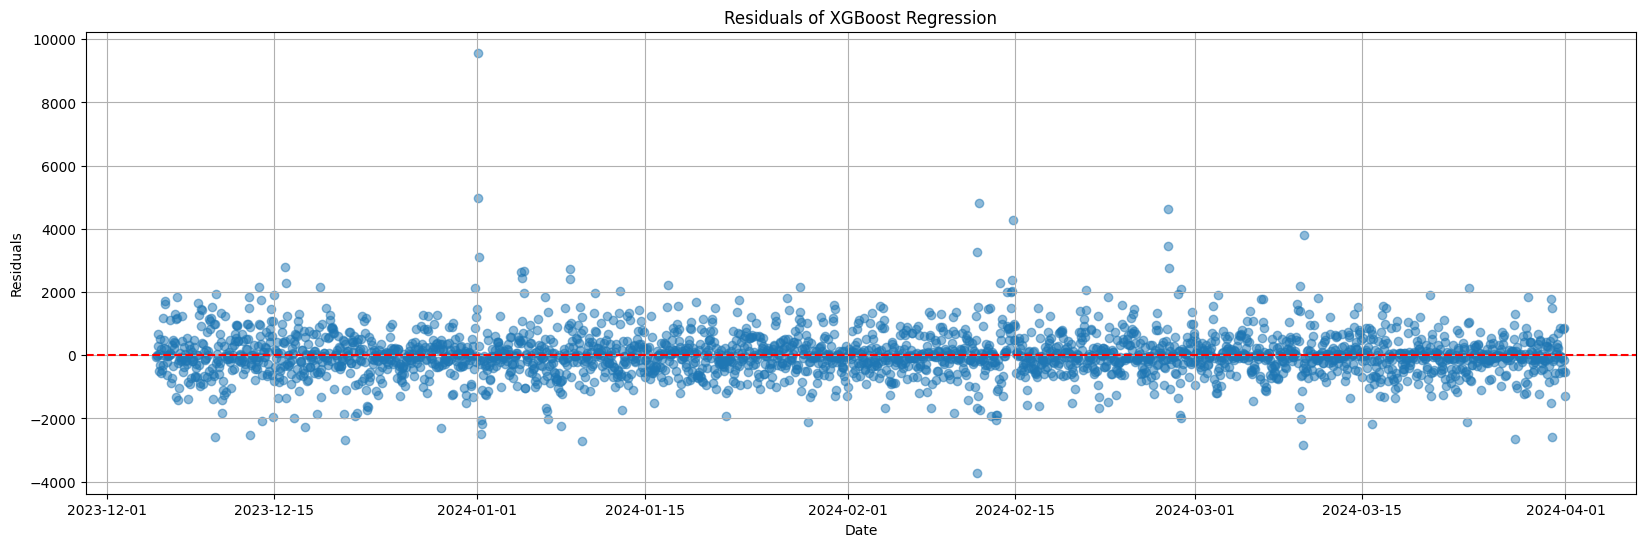

In [134]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(20, 6))

plt.scatter(df['transit_timestamp'].iloc[test_index], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of XGBoost Regression')
plt.grid(True)
plt.show()


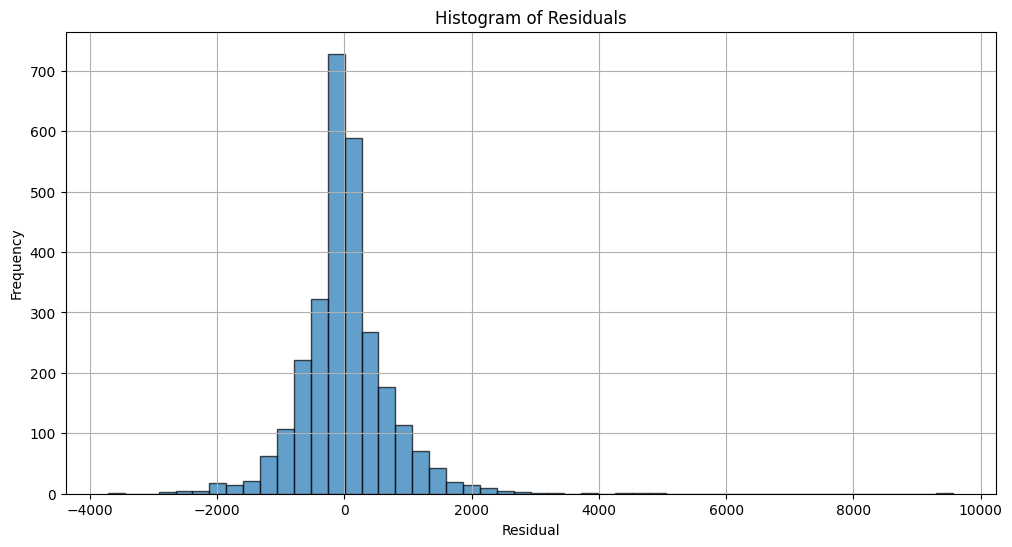

In [135]:
# Plot the histogram of the residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
